In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

In [19]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [20]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys
def readRawData(filePath:str):
    with open(filePath) as file:
        dataString = file.read()
        dataString = dataString.replace("\n"," ")
        dataString = re.sub("[a-zA-Z]+ ","name\n", dataString)
        dataString = dataString.replace(" ",",")
        return dataString

In [21]:
# read the data from the specified datasets into the df
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [22]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

In [23]:
# read the data from the specified datasets into the df
from io import StringIO
dfNew = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ 'new' +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    dfNew = pd.concat([dfNew,dataset_df ], ignore_index=True)

In [24]:
df = df.replace(-9, float('nan'))

In [25]:
irrelevant_columns = [
    "id", # A id is not relevant for a model
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "name" # Constant
]
df.drop(irrelevant_columns, inplace=True, axis=1)

In [26]:
unexplained_columns = [
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "thalsev", # irrelevant according to the uci
    "thalpul", # irrelevant according to the uci
    "earlobe", # Constant
    "lvx1", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx2", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx3", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx4", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvf", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "dummy", # no description available -> from the name does not seem relevant
]
df.drop(unexplained_columns, inplace=True, axis=1)

In [27]:
percentage_missing = ((df.isna().sum()/len(df)*100).round(2)).to_dict()
test = {}
for percentage in np.arange(0,100,0.5):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).dropna(axis=0, how='any').shape

In [28]:
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns"]

In [29]:
test

,rows,columns
0.0,901,1
0.5,897,6
1.0,897,6
1.5,897,6
2.0,897,6
...,...,...
97.5,0,54
98.0,0,54
98.5,0,54
99.0,0,54


Text(0.5, 0, 'minimumPercentageMissingToBeDropped')

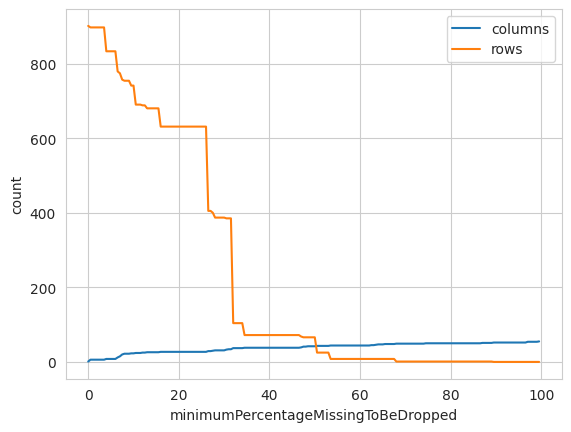

In [37]:
sns.lineplot(data=test, y="columns", x=test.index)
sns.lineplot(data=test, y="rows", x=test.index)
plt.legend(labels=['columns','rows'], facecolor='white')
plt.ylabel('count')
plt.xlabel('minimumPercentageMissingToBeDropped')